In [30]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra \
                    ,calcular_ks_por_safra,monitorar_variaveis_continuas,obter_importancia_variaveis,calcular_metricas_multiplas


In [31]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")

In [32]:
#vamos remover as variáveis que foram reprovadas no teste de estabilidade oot e ver como o modelo se sai
remover_psi_ks_oot = ['VAR_1','VAR_52','VAR_72','VAR_17','VAR_20','VAR_57','VAR_7','VAR_4','VAR_53','VAR_38','VAR_65','VAR_30','VAR_60','VAR_9','VAR_15','VAR_3','VAR_6','VAR_2',
 'VAR_54','VAR_34','VAR_5','VAR_1','VAR_30']

In [33]:
novas_colunas = [x for x in train_selecionada if x not in remover_psi_ks_oot]

In [34]:
train_selecionada = train_selecionada[novas_colunas]

In [35]:
train_selecionada.head()

,id,safra,y,VAR_32,VAR_45,VAR_24,VAR_44,VAR_11,VAR_58,VAR_25,...,VAR_39,VAR_8,VAR_59,VAR_33,VAR_35,VAR_40,VAR_28,VAR_76,VAR_64,VAR_19
0,601,201409,1,0.057198,298.535,305.92,0.0,27.91,262.0,0.0,...,257.0,55.03,249.55,0.0,158.69,0.0,0.0,312.85,1,0.0
1,4320,201409,1,0.090634,298.535,584.92,0.0,43.23,399.0,0.0,...,257.0,124.24,249.55,0.0,172.94,0.0,0.0,312.85,1,0.0
2,8725,201406,1,0.057198,298.535,305.92,0.0,53.55,262.0,0.0,...,257.0,19.40,249.55,0.0,223.84,0.0,0.0,312.85,1,0.0
3,8977,201402,0,0.133833,159.950,306.02,11.0,13.99,267.0,12.0,...,157.0,22.99,331.16,5.0,41.98,11.0,12.0,377.95,0,45.0
4,3547,201402,0,0.090634,298.535,200.55,0.0,53.55,200.0,0.0,...,257.0,39.49,249.55,0.0,223.84,0.0,0.0,312.85,1,0.0


In [36]:
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [37]:
#verificando o schema
train_selecionada.shape,test_oos.shape

((6568, 22), (1643, 22))

In [38]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [39]:
train_selecionada.head()

,id,safra,y,VAR_32,VAR_45,VAR_24,VAR_44,VAR_11,VAR_58,VAR_25,...,VAR_39,VAR_8,VAR_59,VAR_33,VAR_35,VAR_40,VAR_28,VAR_76,VAR_64,VAR_19
0,601,201409,1,0.057198,298.535,305.92,0.0,27.91,262.0,0.0,...,257.0,55.03,249.55,0.0,158.69,0.0,0.0,312.85,1,0.0
1,4320,201409,1,0.090634,298.535,584.92,0.0,43.23,399.0,0.0,...,257.0,124.24,249.55,0.0,172.94,0.0,0.0,312.85,1,0.0
2,8725,201406,1,0.057198,298.535,305.92,0.0,53.55,262.0,0.0,...,257.0,19.40,249.55,0.0,223.84,0.0,0.0,312.85,1,0.0
3,8977,201402,0,0.133833,159.950,306.02,11.0,13.99,267.0,12.0,...,157.0,22.99,331.16,5.0,41.98,11.0,12.0,377.95,0,45.0
4,3547,201402,0,0.090634,298.535,200.55,0.0,53.55,200.0,0.0,...,257.0,39.49,249.55,0.0,223.84,0.0,0.0,312.85,1,0.0


In [41]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oos = aplicar_imputacao_teste(test_oos,regra_imputacao, dict_mediana, dict_media)


In [42]:
train_selecionada.shape, test_oos.shape

((6568, 22), (1643, 22))

In [43]:
#7 min pra treinar com polinomial features
#
train_selecionada, test_oos, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train_selecionada, test_oos, id_col='id', safra_col='safra', target_col='y')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5645,0.6192,0.6469,0.3525,0.4562,0.1431,0.1614,0.1450
lightgbm,Light Gradient Boosting Machine,0.6486,0.5878,0.3189,0.3621,0.3388,0.1010,0.1015,0.2960


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6537,0.5926,0.3234,0.3699,0.3450,0.1111,0.1116
1,0.6294,0.5771,0.2994,0.3289,0.3135,0.0605,0.0606
2,0.6413,0.5849,0.3353,0.3567,0.3457,0.0989,0.0990
3,0.6633,0.6112,0.3533,0.3933,0.3722,0.1431,0.1435
4,0.6396,0.5650,0.2994,0.3425,0.3195,0.0759,0.0762
5,0.6497,0.5918,0.3234,0.3649,0.3429,0.1053,0.1056
6,0.6650,0.6151,0.3174,0.3869,0.3487,0.1261,0.1272
7,0.6650,0.5718,0.2934,0.3798,0.3311,0.1125,0.1142
8,0.6599,0.6071,0.3313,0.3793,0.3537,0.1244,0.1249


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6368,0.6301,0.4611,0.3812,0.4173,0.1570,0.1585
1,0.6345,0.6124,0.4491,0.3769,0.4098,0.1481,0.1492
2,0.6430,0.6285,0.4671,0.3900,0.4251,0.1692,0.1706
3,0.6497,0.6430,0.5210,0.4065,0.4567,0.2040,0.2074
4,0.6193,0.6014,0.4192,0.3535,0.3836,0.1110,0.1119
5,0.6294,0.6092,0.4611,0.3738,0.4129,0.1465,0.1482
6,0.6650,0.6362,0.4850,0.4197,0.4500,0.2109,0.2121
7,0.6413,0.6039,0.3892,0.3714,0.3801,0.1279,0.1280
8,0.6616,0.6638,0.4819,0.4124,0.4444,0.2032,0.2045


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5439,0.6018,0.6467,0.3386,0.4444,0.1177,0.1356
1,0.5702,0.6163,0.6587,0.3583,0.4641,0.1547,0.1749
2,0.6058,0.6326,0.6707,0.3862,0.4902,0.2051,0.2259
3,0.5448,0.6282,0.6587,0.3416,0.4499,0.1238,0.1435
4,0.5601,0.6124,0.6467,0.3495,0.4538,0.1373,0.1556
5,0.5516,0.6286,0.6587,0.3459,0.4536,0.1320,0.1518
6,0.5719,0.6402,0.6647,0.3604,0.4674,0.1593,0.1803
7,0.5804,0.6029,0.5988,0.3559,0.4464,0.1424,0.1550
8,0.5804,0.6692,0.6627,0.3642,0.4701,0.1688,0.1896


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5372,0.6060,0.6467,0.3344,0.4408,0.1097,0.1273
1,0.5719,0.6161,0.6527,0.3586,0.4628,0.1544,0.1737
2,0.6007,0.6322,0.6707,0.3823,0.4870,0.1984,0.2195
3,0.5448,0.6303,0.6647,0.3426,0.4521,0.1263,0.1468
4,0.5533,0.6129,0.6467,0.3450,0.4500,0.1290,0.1472
5,0.5499,0.6272,0.6587,0.3448,0.4527,0.1299,0.1497
6,0.5668,0.6399,0.6587,0.3560,0.4622,0.1505,0.1707
7,0.5956,0.6038,0.6108,0.3696,0.4605,0.1673,0.1809
8,0.5871,0.6713,0.6747,0.3709,0.4786,0.1822,0.2047


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Logistic Regression,0.5645,0.6198,0.6487,0.3530,0.4570,0.1439,0.1624,0.0110
0,Light Gradient Boosting Machine,0.6361,0.6180,0.4532,0.3794,0.4127,0.1523,0.1537,0.0370



🏆 **Modelo Vencedor:** LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
✅ Regressão Logística escolhida com AUC: 0.6198


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6369,0.6222,0.4571,0.3805,0.4153,0.1551,0.1565


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6452,0.6190,0.4557,0.3893,0.4199,0.1666,0.1677


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5618,0.6239,0.6579,0.3520,0.4586,0.1440,0.1640


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5612,0.6204,0.6652,0.3524,0.4607,0.1462,0.1673


base escorada pycaret
        id   safra    VAR_32      VAR_45      VAR_24  VAR_44     VAR_11  \
0      601  201409  0.057198  298.535004  305.920013     0.0  27.910000   
1     4320  201409  0.090634  298.535004  584.919983     0.0  43.230000   
2     8725  201406  0.057198  298.535004  305.920013     0.0  53.549999   
3     8977  201402  0.133833  159.949997  306.019989    11.0  13.990000   
4     3547  201402  0.090634  298.535004  200.550003     0.0  53.549999   
...    ...     ...       ...         ...         ...     ...        ...   
6563  3540  201405  0.133833  163.919998  235.869995     9.0  53.549999   
6564  2939  201409  0.020019  298.535004  305.920013     0.0  46.049999   
6565  3729  201405  0.133833  394.299988  245.410004     2.0  53.549999   
6566  4807  201402  0.090634  298.535004  305.920013     0.0  79.639999   
6567  9921  201405  0.133833  247.610001  305.920013     0.0  53.549999   

      VAR_58  VAR_25  VAR_22  ...      VAR_35  VAR_40  VAR_28      VAR_76  \


In [44]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]

In [45]:
test_oot.shape

(2527, 22)

In [46]:
#### Escoragem dos Modelos no dataset de OOT ####
#Primeiro vamos aplicar a regra de imputação de missings
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oot = aplicar_imputacao_teste(test_oot,regra_imputacao, dict_mediana, dict_media)


In [47]:
#Agora basta escorar a base oot nos dois modelos

# 🔹 ESCORAGEM DOS MODELOS

# Aplicando LightGBM no conjunto de treino e teste
test_oot_lightgbm = predict_model(tuned_lightgbm, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_lightgbm = test_oot_lightgbm[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6332,0.6241,0.4384,0.4305,0.4344,0.1630,0.1630


In [48]:
test_oot_regressao = predict_model(tuned_lr, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_regressao = test_oot_regressao[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5817,0.6245,0.6355,0.4041,0.4940,0.1666,0.1791


In [49]:
train_lightgbm_escorado.head()

,id,safra,y,score_1,score_0
0,601,201409,1,0.5692,0.4308
1,4320,201409,1,0.5472,0.4528
2,8725,201406,1,0.5731,0.4269
3,8977,201402,0,0.3187,0.6813
4,3547,201402,0,0.5425,0.4575


In [50]:
test_oot_regressao.head()

,id,safra,y,score_0,score_1
0,4,201412,0,0.5663,0.4337
1,13,201411,1,0.4138,0.5862
2,15,201412,0,0.5655,0.4345
3,17,201412,0,0.5294,0.4706
4,20,201411,0,0.6028,0.3972


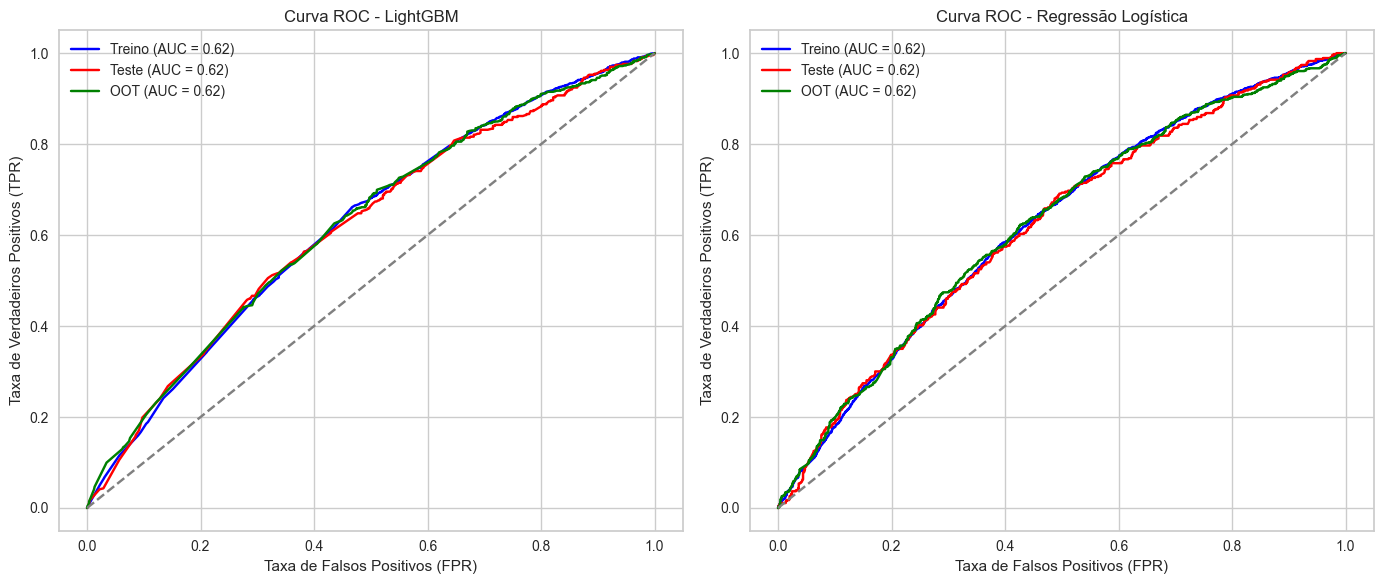

In [51]:
#1. Curva ROC (Receiver Operating Characteristic)
#Mostra a relação entre Taxa de Verdadeiros Positivos (TPR - Sensibilidade) e Taxa de Falsos Positivos (FPR).
#Quanto mais próxima a curva estiver do canto superior esquerdo, melhor o modelo.
#A métrica principal associada é a AUC-ROC (Área sob a Curva ROC), que indica a capacidade do modelo em distinguir classes.
#Usar com objetivo for avaliar o quão bem o modelo separa as classes, independentemente da distribuição dos dados.

plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

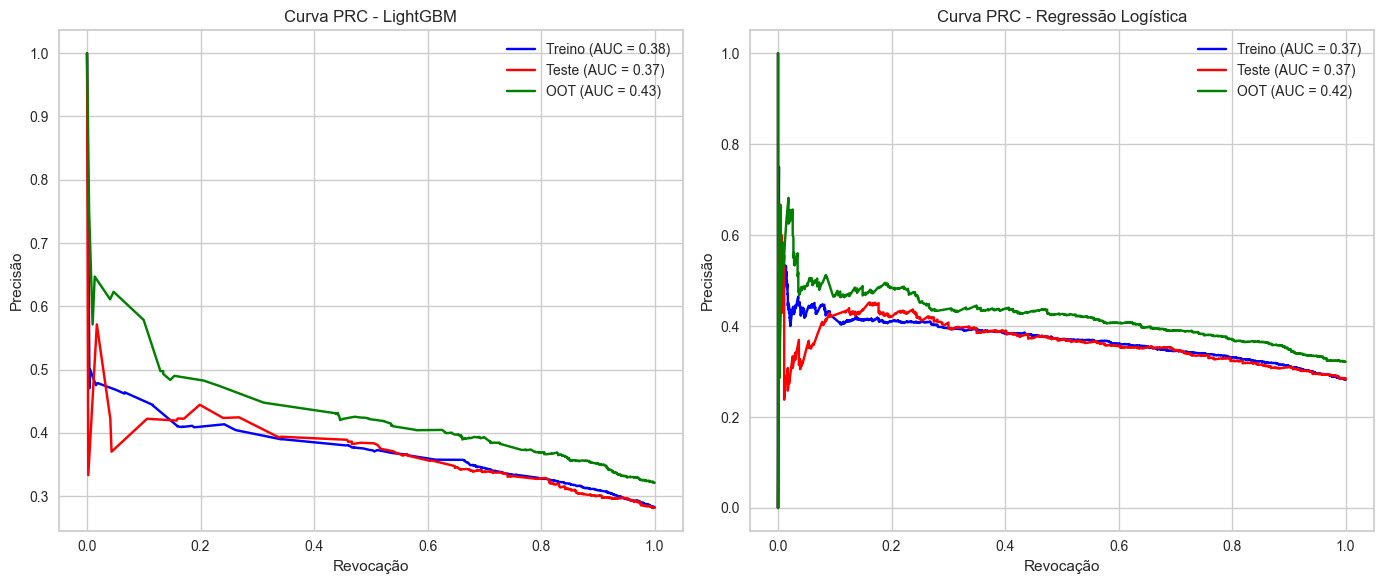

In [52]:
#2. Curva PRC (Precision-Recall Curve)
#Mostra a relação entre Precisão (Precision) e Revocação (Recall - Sensibilidade).
#Útil quando a classe positiva é rara (dados desbalanceados).
#A métrica associada é a AUC-PR, que mede a área sob essa curva.
#Se houver um grande desbalanceamento entre as classes (por exemplo, detecção de fraudes, doenças raras).

plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

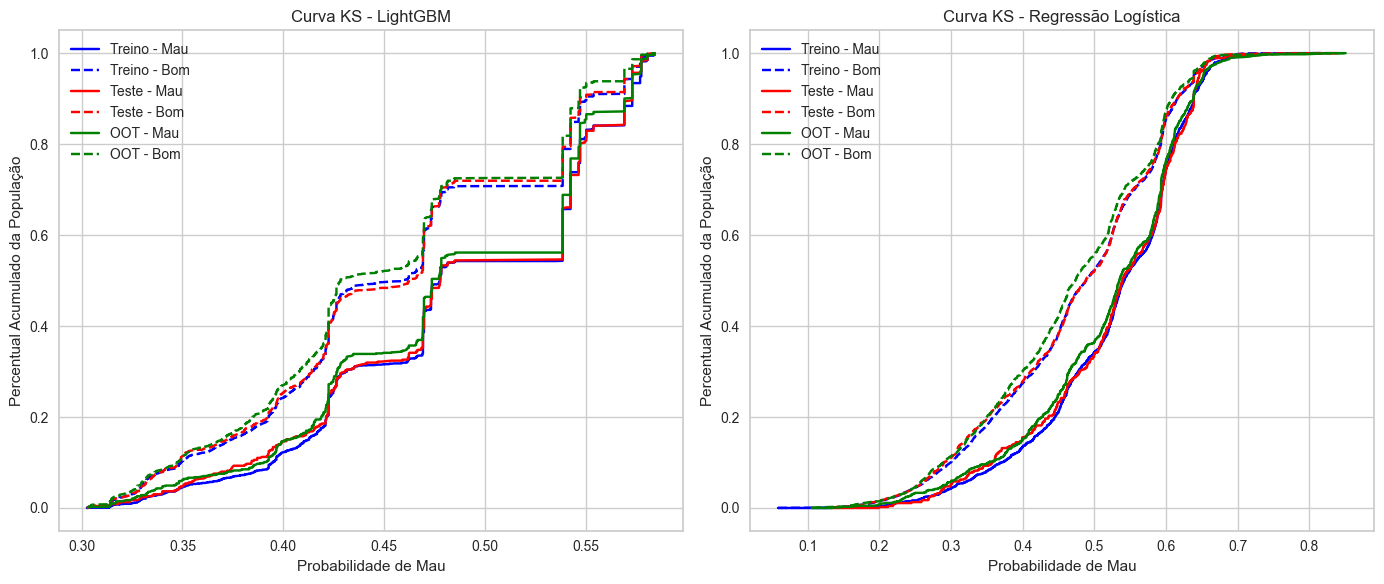

In [53]:
#3. Curva KS (Kolmogorov-Smirnov Curve)
#Mede a diferença máxima entre as distribuições cumulativas de positivos e negativos.
#Quanto maior o valor de KS, melhor a separação do modelo.
#Muito utilizada em modelos de risco de crédito e em cenários onde se quer saber o ponto de máxima separação entre as classes.

plot_comparacao_ks(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

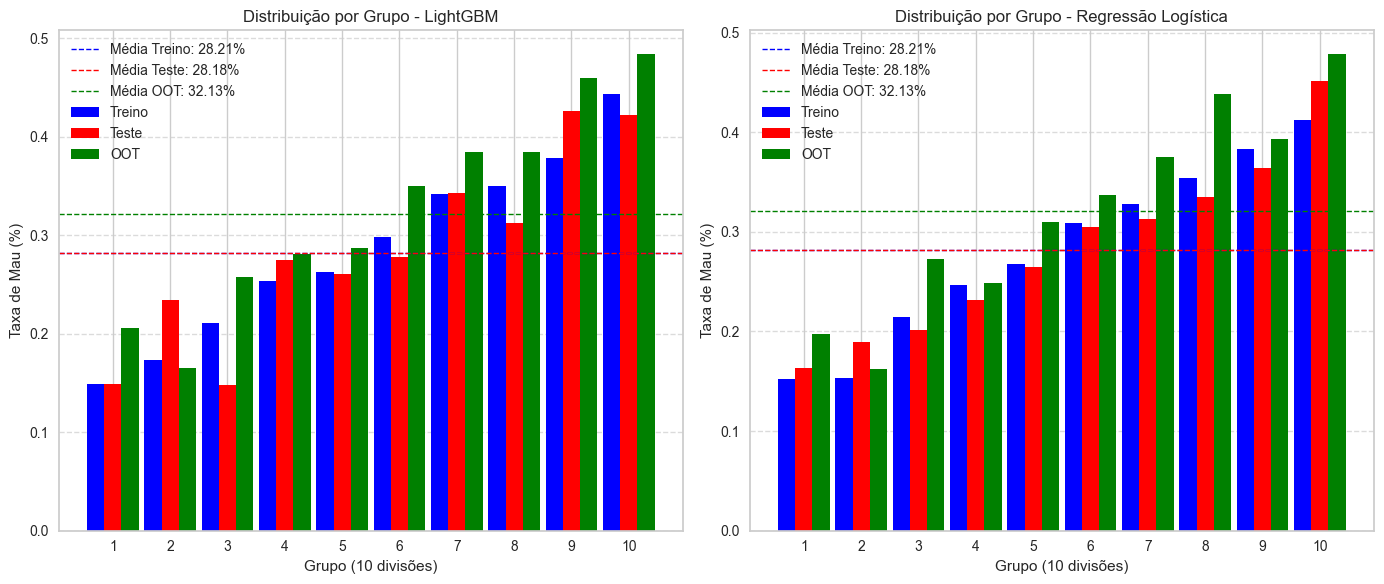

In [54]:
#Verificar se o score está ordenando bem e seguindo uma lógica onde quanto maior a probabilidade de mau, maior o % de maus acumulados
#Ordenamos o score do menor para o maior 
#Criamos faixas discretas e verificamos a quantidade de maus em cada faixa
#Quanto mais ordenadas forem as faixas melhor
plot_comparacao_decil(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [55]:
tabela = gerar_tabela_avaliacao(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [56]:
tabela['nome_dataframe'].unique().tolist()

['Train LightGBM',
 'Test LightGBM',
 'Train Regressão',
 'Test Regressão',
 'OOT LightGBM',
 'OOT Regressão']

In [57]:
tabela[tabela['nome_dataframe']=="OOT LightGBM"].head(10)

,nome_dataframe,quantil,score_0 min,score_0 max,total_casos,total_mau,total_bom,maus_acumulados,% maus acumulados,KS
40,OOT LightGBM,1,0.6486,0.6969,253,52,201,52,6.403941,5.316176
41,OOT LightGBM,2,0.6051,0.6482,260,43,217,95,11.699507,12.673670
42,OOT LightGBM,3,0.5816,0.6049,245,63,182,158,19.458128,15.527295
43,OOT LightGBM,4,0.5752,0.5813,253,71,182,229,28.201970,17.395697
44,OOT LightGBM,5,0.5310,0.5750,261,75,186,304,37.438424,19.004725
45,OOT LightGBM,6,0.5263,0.5307,300,105,195,409,50.369458,17.443953
46,OOT LightGBM,7,0.4614,0.5260,390,150,240,559,68.842365,12.965216
47,OOT LightGBM,8,0.4575,0.4575,169,65,104,624,76.847291,11.024429
48,OOT LightGBM,9,0.4504,0.4535,150,69,81,693,85.344828,7.249925
49,OOT LightGBM,10,0.4158,0.4497,246,119,127,812,100.000000,0.000000


In [58]:
#ks por safra publico completo lightgbm
tabela_ks = calcular_ks_por_safra(pd.concat([train_lightgbm_escorado,test_lightgbm_escorado,test_oot_lightgbm]))

In [59]:
tabela_ks

,safra,contagem_de_linhas,ks_max,ponto_ks
0,201401,854,22.871258,0.4779
1,201402,898,27.385985,0.4693
2,201403,873,26.133304,0.4264
3,201404,955,16.570917,0.4268
4,201405,972,15.470904,0.5386
5,201406,902,16.334666,0.5386
6,201407,968,15.959602,0.4693
7,201408,912,24.177978,0.4693
8,201409,877,24.842397,0.4730
9,201410,933,23.819481,0.4657


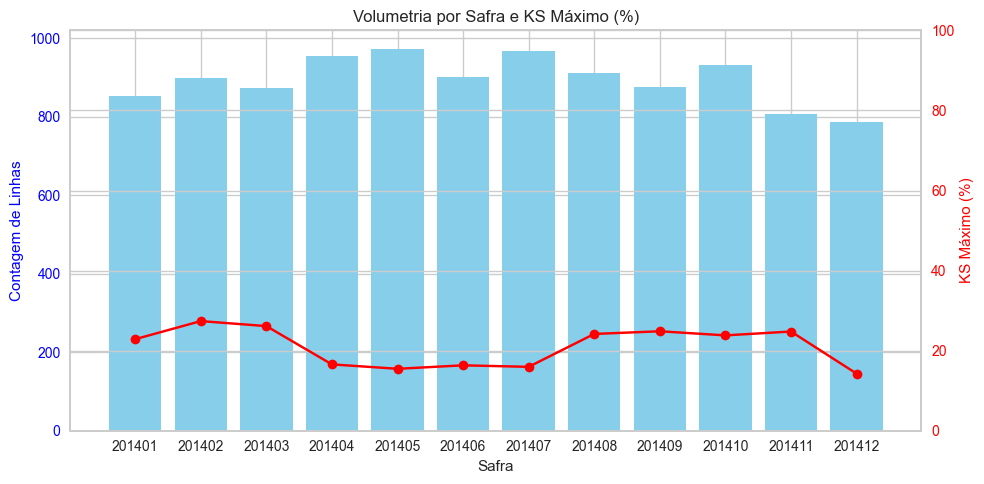

In [60]:
plotar_ks_safra(tabela_ks)

In [61]:
# O que leva nosso modelo a perder performance no OOT?
#Se o modelo perdeu performance no OOT, algumas causas podem ser:
#
#Mudança nos dados – Os padrões dos dados mudaram com o tempo.
#Mudança na relação com a target – As variáveis deixaram de influenciar o resultado da mesma forma.
#Overfitting – O modelo aprendeu muito bem o treino, mas não generaliza para novos períodos.
#Dados desatualizados – O treino foi feito com dados antigos e não reflete a realidade atual.
#Erros no processamento – Alguma transformação nos dados do OOT pode estar errada.
#Fatores externos – Eventos novos afetaram o comportamento dos dados (ex: crise, novas regras).

In [62]:
#Importancia de variáveis non light gbm (quantas vezes a variável foi utilizada para realizar o corte na folha da árvore)
#Os betas (β) na Regressão Logística são os coeficientes que medem o efeito de cada variável independente na probabilidade de um determinado evento ocorrer.

df_lgbm_vars = obter_importancia_variaveis(tuned_lightgbm, "LightGBM")
df_logistica_vars = obter_importancia_variaveis(tuned_lr, "Regressão Logística")

In [63]:
#Se uma variável que é importante para o modelo muda de distribuição, isso pode causar problemas na previsão.

#O p-valor mede a probabilidade de observarmos uma diferença tão grande entre duas amostras apenas por acaso, assumindo que elas vêm da mesma distribuição.
#Se p-valor < 0.05 → Existe menos de 5% de chance de que a diferença seja mero acaso. Ou seja, há evidências estatísticas de que as distribuições são diferentes!
#Se p-valor >= 0.05 → Não há evidências suficientes para afirmar que as distribuições mudaram.
#No caso do KS Test (Kolmogorov-Smirnov), um p-valor < 0.05 indica que a distribuição da variável mudou significativamente entre a safra de referência e a safra atual.

#O PSI (Índice de Estabilidade Populacional) mede a diferença entre duas distribuições.
#Dividimos os dados em faixas de valores, Calculamos as frequências relativas em cada bin para ambas as populações (referência e atual).
#PSI < 0.1 → Pequena diferença (distribuição estável)
#0.1 ≤ PSI < 0.25 → Diferença moderada (monitorar)
#PSI ≥ 0.25 → Diferença significativa (possível problema )


psi,ks = monitorar_variaveis_continuas(pd.concat([train_selecionada,test_oos]), test_oot, [x for x in train_selecionada.columns if x not in ['id','safra','y']])

In [77]:
ks

""


In [78]:
psi

""


In [65]:
avaliar_vars_ks = df_lgbm_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [66]:
avaliar_vars = avaliar_vars_ks.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [76]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
#train_selecionada['VAR_1'].mean(),test_oos['VAR_1'].mean(),test_oot['VAR_1'].mean()

In [68]:
avaliar_vars

,nome_variavel,importancia,index_x,index_y
0,VAR_32,240,NaN,NaN
1,VAR_64,222,NaN,NaN
2,VAR_25,113,NaN,NaN
3,VAR_22,69,NaN,NaN
4,VAR_44,61,NaN,NaN
5,VAR_8,37,NaN,NaN
6,VAR_35,22,NaN,NaN
7,VAR_76,17,NaN,NaN
8,VAR_33,16,NaN,NaN
9,VAR_24,1,NaN,NaN


In [69]:
avaliar_vars_ks_lr = df_logistica_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [70]:
avaliar_vars_lr = avaliar_vars_ks_lr.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [71]:
avaliar_vars_lr

,nome_variavel,importancia,index_x,index_y
0,VAR_22,-0.200601,NaN,NaN
1,VAR_32,-0.162350,NaN,NaN
2,VAR_11,-0.162089,NaN,NaN
3,VAR_25,-0.151634,NaN,NaN
4,VAR_64,0.125833,NaN,NaN
5,VAR_35,0.098301,NaN,NaN
6,VAR_8,0.087985,NaN,NaN
7,VAR_76,0.069208,NaN,NaN
8,VAR_33,0.034846,NaN,NaN
9,VAR_24,-0.021138,NaN,NaN


In [72]:
# Vamos salvar as bases escoradas para podermos avaliar melhor o modelo com métricas que dependem do Limiar de corte

#train_lightgbm_escorado.to_csv("train_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_lightgbm_escorado.to_csv("test_lightgbm_escorado.csv",sep=",",index=False,header=True)
#train_regressao_escorado.to_csv("train_regressao_escorado.csv",sep=",",index=False,header=True)
#test_regressao_escorado.to_csv("test_regressao_escorado.csv",sep=",",index=False,header=True)
#test_oot_lightgbm.to_csv("test_oot_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_oot_regressao.to_csv("test_oot_regressao_escorado.csv",sep=",",index=False,header=True)

In [75]:
bases_nomeadas = {
    "Train - LightGBM": train_lightgbm_escorado,
    "Test - LightGBM": test_lightgbm_escorado,
    "OOT - LightGBM": test_oot_lightgbm,
    "Train - Regressão Logística": train_regressao_escorado,
    "Test - Regressão Logística": test_regressao_escorado,
    "OOT - Regressão Logística": test_oot_regressao
}
calcular_metricas_multiplas(bases_nomeadas, limiar = 0.5)

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,Train - LightGBM,0.6369,0.3805,0.4571,0.4153,0.6222,0.1945,0.2444,847,1379,3336,1006
1,Test - LightGBM,0.6452,0.3893,0.4557,0.4199,0.6190,0.1868,0.2381,211,331,849,252
2,OOT - LightGBM,0.6332,0.4305,0.4384,0.4344,0.6241,0.1900,0.2482,356,471,1244,456
3,Train - Regressão Logística,0.5618,0.3520,0.6579,0.4586,0.6239,0.1875,0.2477,1219,2244,2471,634
4,Test - Regressão Logística,0.5612,0.3524,0.6652,0.4607,0.6204,0.1954,0.2409,308,566,614,155
5,OOT - Regressão Logística,0.5817,0.4041,0.6355,0.4940,0.6246,0.1963,0.2491,516,761,954,296
